# Comparison of developed calibration implementation and OpenCV

## Table of Contens
1. [Helper Functions](#helper-functions)
2. [Calibration Data Extraction](#calibration-data-extraction)
3. [Comparsion](#comparsion)
   1. [Closed Form Solution]()
      1. [Homography](#homography)
      2. [Camera Matrix](#camera-matrix)
      3. [Rotation and Translation Vectors](#rotation-and-translation-vectors)
   2. [Calibration](#calibration)
      1. [Given an initial Guess](#given-an-initial-guess)
      2. [Estimating an initail Guess](#estimating-an-initial-guess)
   3. [Undistortion](#undistortion)
      1. [Original Image Shape]()
      2. [Resized Image Shape]()


In [26]:
%matplotlib widget
import numpy as np
import cv2 as cv
import os
import camera_model as cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import time
import homography as hom

# Helper Functions

In [ ]:
def rot_around_axis(vector, axis, angle):
	"""Helper function to rotate a vector around the normed axis n by the specified angle.

	Args:
		vector: 3D vector Vector to rotate.
		axis: 3D normed axis of rotation.
		angle: Angle to rotate in rad. The sign is defined by the right hand rule.

	Returns:
		Rotated vector.
	"""

	# perform a rotation according to rodrigues
	# v' = v*cos(phi)+(axis x v)*sin(phi)+axis * (axis * v)*(1-cos(phi))
	# with phi = norm(axis)

	# as matrix (Rotationmatrix) => faster
	# reuse the cos and sin
	cAng = np.cos(angle)
	sAng = np.sin(angle)
	# reuse the value of 1-cos (shifted cos)
	s_CAng = 1 - cAng

	rotMat = np.array([	[cAng + axis[0]**2*s_CAng, axis[0]*axis[1]*s_CAng - axis[2]*sAng, axis[0]*axis[2]*s_CAng + axis[1]*sAng],
						[axis[0]*axis[1]*s_CAng + axis[2]*sAng, cAng + axis[1]**2*s_CAng, axis[1]*axis[2]*s_CAng - axis[0]*sAng],
						[axis[0]*axis[2]*s_CAng - axis[1]*sAng, axis[1]*axis[2]*s_CAng + axis[0]*sAng, cAng + axis[2]**2*s_CAng]])

	v_rot = np.matmul(rotMat, vector)
	return v_rot

def plot_views(rVecs, tVecs, title = ""):
	"""Helper Function to plot visualise the recorded views.

	Args:
		rVecs (_type_): Rotation Vectors.
		tVecs (_type_): Translation Vectors.
		title (str, optional): Title of the generated plot. Defaults to "".
	"""

	# Points of a plane
	p1 = np.array([0,0,0])
	p2 = np.array([30*9,0,0])
	p3 = np.array([30*9,30*6,0])
	p4 = np.array([0,30*6,0])

	fig = plt.figure()
	ax = Axes3D(fig, auto_add_to_figure=False)
	fig.add_axes(ax)
	x = np.array([100,100,-100,-100])
	y = np.array([100,-100,-100,100])
	z = np.array([0,0,0,0])

	verts = [list(zip(x, y, z))]
	collection = Poly3DCollection(verts, linewidths=2, alpha=0.5)
	face_color = [1, 0, 0]
	edge_color = [0,0,0]
	collection.set_facecolor(face_color)
	collection.set_edgecolor(edge_color)
	ax.add_collection3d(collection)


	for viewIdx in range(0,len(rVecs)):
		rVec = rVecs[viewIdx].reshape(3,)
		tVec = tVecs[viewIdx].reshape(3,)
		#rVec = np.array([np.pi*2, 0,0])
		axis = rVec/np.linalg.norm(rVec)
		angle = np.linalg.norm(rVec)
		p1_rot = rot_around_axis(p1,axis,angle)+tVec
		p2_rot = rot_around_axis(p2,axis,angle)+tVec
		p3_rot = rot_around_axis(p3,axis,angle)+tVec
		p4_rot = rot_around_axis(p4,axis,angle)+tVec
		
		x = np.array([p1_rot[0],p2_rot[0],p3_rot[0],p4_rot[0],p1_rot[0]])
		y = np.array([p1_rot[1],p2_rot[1],p3_rot[1],p4_rot[1],p1_rot[1]])
		z = np.array([p1_rot[2],p2_rot[2],p3_rot[2],p4_rot[2],p1_rot[2]])

		verts = [list(zip(x, y, z))]
		collection = Poly3DCollection(verts,linewidths=2,alpha=0.2)
		face_color = [0, 0, 1]
		edge_color = [0,0,0]
		collection.set_facecolor(face_color)
		collection.set_edgecolor(edge_color)
		ax.add_collection3d(collection)
	
	# Set the axes labels
	ax.set_xlabel('x')
	ax.set_ylabel('y')
	ax.set_zlabel('z')

	ax.set_xlim([-250,250])
	ax.set_ylim([-250,250])
	ax.set_zlim([0,500])
	fig.suptitle(title)
	plt.show()

	def plot_per_view_reprojection_error():
		pass

## Calibration Data Extraction
This cell extracts the object points and the image points needed for calibration. For this purpose OpenCVs `findChessboardCorners()` and `cornerSubPix` are used, since this semester work focuses on implementing a camera calibration.

C:\Users\samih\AppData\Local\Temp\ipykernel_7144\1320933224.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_image_collage = plt.figure()


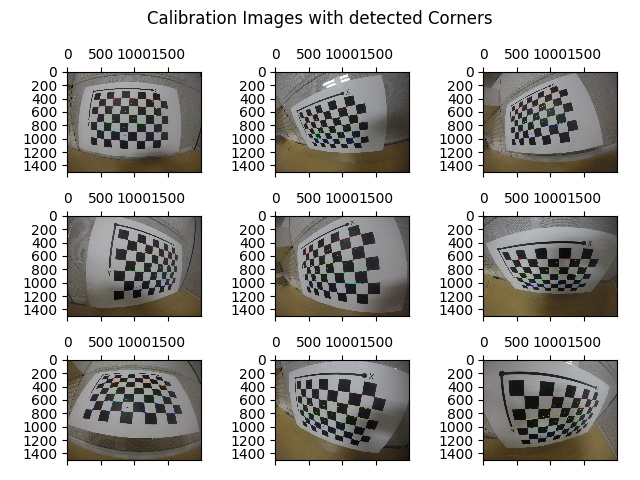

In [36]:
# Checkerboard square size
SQUARE_SIZE = 29 # mm
SQUARE_WIDTH = 9
SQUARE_HIGHT = 6

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((SQUARE_WIDTH*SQUARE_HIGHT,3), np.float32)
objp[:,:2] = np.mgrid[0:SQUARE_WIDTH,0:SQUARE_HIGHT].T.reshape(-1,2)*SQUARE_SIZE
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

imgs = []

images = os.listdir("../calibration_images/")
for imageIdx, fname in enumerate(images):
	img = cv.imread("../calibration_images/"+fname)
	gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
	# Find the chess board corners
	ret, corners = cv.findChessboardCorners(gray, (SQUARE_WIDTH,SQUARE_HIGHT), None)
	# If found, add object points, image points (after refining them)
	if ret == True:
		objpoints.append(objp)
		corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
		imgpoints.append(corners2.reshape(SQUARE_WIDTH*SQUARE_HIGHT,2))
		# Draw and display the corners
		cv.drawChessboardCorners(img, (SQUARE_WIDTH,SQUARE_HIGHT), corners2, ret)
		# convert to RGB
		img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
		imgs.append(img)

imageSize = img.shape[0:2]

# Display the images
fig_image_collage = plt.figure()
fig_image_collage.suptitle("Calibration Images with detected Corners")
cols = 3
rows = int(len(imgs)/3)
if len(imgs)%3 != 0:
	rows += 1

for n in range(0,rows*cols):
	ax = plt.subplot(rows,cols,n+1)
	ax.matshow(imgs[n])

fig_image_collage.tight_layout()
plt.show()

## Comparsion

### Closed From Solution

#### Homography
Comparison of the own implementatoin of the homography calculation and OpenCVs `cv2.findHomography()` implementation.

In [30]:
print("Starting homography calculation with OpenCV:")
startTime = time.time()
H_matrix_CV, _ = cv.findHomography(objpoints[0], imgpoints[0])
stopTime = time.time()
print(f"Homography calculation took {stopTime-startTime} s.\n")

print("Starting homography calculation with Own Implementation:")
startTime = time.time()
H_matrix = hom.compute_homography(objpoints[0], imgpoints[0])
stopTime = time.time()
print(f"Homography calculation took {stopTime-startTime} s.\n")

print("Comparison OpenCV and Own Implementation")
print("Homography Matrix")
print(f"OpenCV:\n{H_matrix_CV}")
print(f"OwnImpl:\n{H_matrix}")

Starting homography calculation with OpenCV:
Homography calculation took 0.0009961128234863281 s.

Starting homography calculation with Own Implementation:
Homography calculation took 0.00922703742980957 s.

Comparison OpenCV and Own Implementation
Homography Matrix
OpenCV:
[[ 3.81254882e+00 -4.61078803e-01  4.71477944e+02]
 [-1.59769467e-02  3.75499968e+00  4.08186307e+02]
 [-1.69898516e-04 -3.63255627e-04  1.00000000e+00]]
OwnImpl:
[[ 3.73683361e+00 -5.11255666e-01  4.75374700e+02]
 [-4.80705297e-02  3.68047421e+00  4.10921262e+02]
 [-2.10478357e-04 -4.13348492e-04  1.00000000e+00]]


#### Camera Matrix
This section computes the initial camera matrix according to Zhangs closed form solution. The estimated matrixes coherence is evaluated by comparing to the camera matrix calibration result given by OpenCVs `cv2.calibrateCamera()` function.

In [40]:
print("Starting Camera Matrix Estimation with Own Implementation:")
startTime = time.time()
# Estiamation via closed form solution
homographies = []
for viewIdx in range(0,len(objpoints)):
	homography = hom.compute_homography(objpoints[viewIdx], imgpoints[viewIdx])
	homographies.append(homography)
# set camera matrix
camera_matrix_init = hom.estimate_overall_camera_matrix(homographies, imageSize)
stopTime = time.time()
print(f"Homography calculation took {stopTime-startTime} s.\n")

# opencv ground truth
_, camera_matrix_CV, _, _, _ = cv.calibrateCamera(objpoints, imgpoints, imageSize[::-1], None, None)

print("Overall")
print("Camera Matrix")
print(f"OpenCV final estimation:\n{camera_matrix_CV}")
print(f"OwnImpl init guess:\n{camera_matrix_init}")

Starting Camera Matrix Estimation with Own Implementation:
Homography calculation took 0.02124166488647461 s.

Overall
Camera Matrix
OpenCV final estimation:
[[8.76284051e+02 0.00000000e+00 1.00892486e+03]
 [0.00000000e+00 8.74794296e+02 7.40760123e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
OwnImpl init guess:
[[7.26622883e+02 0.00000000e+00 1.01920231e+03]
 [0.00000000e+00 7.11690986e+02 7.10955295e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Calibration
#### Given an initial Guess
By giving the optional input parameters to `cv2.calibrateCamera()` and `CameraModel.calibrate()`, the given extrinsics and the initial camera matrix are used as an intial guess for the refinement with the Levenberg-Marquardt Algorithm like described in the documentation. If the results are close to each other, this indicates that the own implementatoin of the Levenberg Marquardt implementation finds the same minumum as the OpenCV implementation.

In [ ]:
# give hard coded camera matrix, rotation vectors and translation vectors
camera_matrix = np.array([[870,0,1000],[0,870,740],[0,0,1]])
r_vecs = [	np.array([-0.0712924812009836,-0.0292175394495124,0.0255851671102674]),
			np.array([0.360041341702118,0.292270489326601,-0.196294514895238]),
			np.array([-0.21685203707621,0.342032686268539,-0.194822354948762]),
			np.array([0.025707900966097,-0.38269109027857,0.0835269020293139]),
			np.array([0.012599678183883,0.455443059959900,-0.121760978578204]),
			np.array([0.675036205672978,0.106074888811669,-0.037364637599321]),
			np.array([-0.49397086677120,0.003248176783629,0.0475662120021422]),
			np.array([0.379321351852082,0.277671281710087,0.151292570222135]),
			np.array([0.514280045619162,-0.33317568201159,0.0553282501422906])]
t_vecs = [	np.array([-133.570266932208,-82.3866893386230,194.908550346452]),
			np.array([-179.746809682451,-15.5208806619914,241.383487460901]),
			np.array([-184.598770979657,-56.4084249094453,269.570942897015]),
			np.array([-18.1421310225256,-70.1671640289872,157.008019895543]),
			np.array([-162.636947702008,-46.6921260076341,228.102404155863]),
			np.array([-122.945298690088,-15.8962246507799,162.422034456029]),
			np.array([-113.146369394761,-125.398395217610,212.631108594461]),
			np.array([-149.250701390887,-72.3823831078885,173.640576462723]),
			np.array([-49.8586717452160,-24.7843164485865,104.292254178919])]

# compare the parameters
# Calibrate with OpenCV
print("Starting calibration with OpenCV:")
startTime = time.time()
RMSErrorCV, cameraMatrixCV, distortionVecCV, rVecsCV, tVecsCV = cv.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], camera_matrix, None, r_vecs, t_vecs)
stopTime = time.time()
print(f"Calibration took {stopTime-startTime} s.\n")

# Calibrate with own implementation
print("Starting calibration with own implementation:")
startTime = time.time()
cam = cm.CameraModel()
RMSError, rVecs, tVecs = cam.calibrate(objpoints,imgpoints,gray.shape,camera_matrix,r_vecs,t_vecs,verbose=False)
cam.save_cam_to_json("test.json")
stopTime = time.time()
print(f"Calibration took {stopTime-startTime} s.\n")

print("Comparison OpenCV and Own Implementation")
print("RMS-Reprojection-Error")
print(f"OpenCV:\t\t{RMSErrorCV}")
print(f"OwnImpl:\t{RMSError}")
print("Camera Matrix")
print(f"OpenCV:\t\t{cameraMatrixCV}")
print(f"OwnImpl:\t{cam.cameraMat}")
print("Distortion Coefficients")
print(f"OpenCV:\t\tk1={distortionVecCV[0,0]}, k2={distortionVecCV[0,1]}, k3={distortionVecCV[0,4]}, p1={distortionVecCV[0,2]}, p2={distortionVecCV[0,3]}")
print(f"OwnImpl:\tk1={cam.distortionVec[0]}, k2={cam.distortionVec[1]}, k3={cam.distortionVec[2]}, p1={cam.distortionVec[3]}, p2={cam.distortionVec[4]}")

plot_views(rVecsCV,tVecsCV,title="Estimated Views OpenCV")
plot_views(rVecs,tVecs,title="Estimated Views OwnImp")

#### Estimating an initial Guess
By not giving the optional input parameters to `cv2.calibrateCamera()` and `CameraModel.calibrate()`, the extrinsics and initial camera matrix are estimated according to the Closed Form Solution, described in the documentation.

In [ ]:
r_vecs = None
t_vecs = None
camera_matrix = None
# Calibrate with OpenCV
print("Starting calibration with OpenCV:")
startTime = time.time()
RMSErrorCV, cameraMatrixCV, distortionVecCV, rVecsCV, tVecsCV = cv.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], camera_matrix, None, r_vecs, t_vecs)
stopTime = time.time()
print(f"Calibration took {stopTime-startTime} s.\n")

# Calibrate with own implementation
print("Starting calibration with own implementation:")
startTime = time.time()
cam = cm.CameraModel()
RMSError, rVecs, tVecs = cam.calibrate(objpoints,imgpoints,gray.shape[0:2],camera_matrix,r_vecs,t_vecs)
stopTime = time.time()
cam.save_cam_to_json("cam_intrinsics.json")
print(f"Calibration took {stopTime-startTime} s.\n")

print("Comparison OpenCV and Own Implementation")
print("RMS-Reprojection-Error")
print(f"OpenCV:\t\t{RMSErrorCV}")
print(f"OwnImpl:\t{RMSError}")
print("Camera Matrix")
print(f"OpenCV:\t\t{cameraMatrixCV}")
print(f"OwnImpl:\t{cam.cameraMat}")
print("Distortion Coefficients")
print(f"OpenCV:\t\tk1={distortionVecCV[0,0]}, k2={distortionVecCV[0,1]}, k3={distortionVecCV[0,4]}, p1={distortionVecCV[0,2]}, p2={distortionVecCV[0,3]}")
print(f"OwnImpl:\tk1={cam.distortionVec[0]}, k2={cam.distortionVec[1]}, k3={cam.distortionVec[2]}, p1={cam.distortionVec[3]}, p2={cam.distortionVec[4]}")

plot_views(rVecsCV,tVecsCV,"Estimated Views OpenCV")
plot_views(rVecs,tVecs,"Estimated Views OwnImp")

### Undistortion
#### Original Image Shape
In this section a calibration sample image is undistorted with OpenCVs `undistort()` using the coefficients determined by OpenCVs `calibrateCamera()` and using the coefficients determined by the own calibration implementation `CameraModel.calibrate()`. Following the undistortion is performed by the own implementation of the undistortion method found in the CameraModel class `CameraModel.undistortImage()`. If plot b) and plot c) look the same, this would show, that our implementation of the undistortion method works fine. The last plot d) then shows the effects on the undistortion caused by the deviances of the intrinsic camera parameters.

In [ ]:
# Read the image and convert to RGB
img = cv.imread("C:/Program Files/MATLAB/R2022b/toolbox/vision/visiondata/calibration/gopro/"+images[0])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Undistortion
print("Starting undistortion with OpenCV:")
startTime = time.time()
undist_imgCV = cv.undistort(img,cameraMatrixCV,distortionVecCV)
stopTime = time.time()
print(f"Undistortion took {stopTime-startTime} s.\n")

undist_imgCV_own_params = cv.undistort(img,cam.cameraMat,np.array([cam.distortionVec[0],cam.distortionVec[1],cam.distortionVec[3],cam.distortionVec[4],cam.distortionVec[2]]))

print("Starting undistortion with own implementation:")
startTime = time.time()
undist_img = cam.undistort_image(img)
stopTime = time.time()
print(f"Undistortion took {stopTime-startTime} s.\n")

# Visualisation
fig = plt.figure()
ax = plt.subplot(2,2,1)
ax.set_title("a) Distorted Image")
ax.matshow(img)
ax = plt.subplot(2,2,2)
ax.set_title("b) Undistorted Image OpenCV (OpenCV Params)")
ax.matshow(undist_imgCV)
ax = plt.subplot(2,2,3)
ax.set_title("c) Undistorted Image OpenCV (OwnImp Params)")
ax.matshow(undist_imgCV_own_params)
ax = plt.subplot(2,2,4)
ax.set_title("d) Undistorted Image OwnImp (OwnImp Params)")
ax.matshow(undist_img)
fig.tight_layout()

#### Resized Image Shape
In addition to the previous section, this section demonstrates, that the undistortion function automatically adapts the camera matrix for resized images. Therefore the calibration for a camera object must only be performed once.

In [ ]:
# Read the image and convert to RGB
img = cv.imread("C:/Program Files/MATLAB/R2022b/toolbox/vision/visiondata/calibration/gopro/"+images[0])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resized = cv.resize(img,(int(img.shape[1]/2),int(img.shape[1]/4)))

# Undistortion
undist_img_original = cam.undistort_image(img)
undist_img_resized = cam.undistort_image(img_resized)

# Visualisation
fig = plt.figure()
ax = plt.subplot(1,2,1)
ax.set_title("a) Undistorted Image Original")
ax.matshow(undist_img_original)
ax = plt.subplot(1,2,2)
ax.set_title("b) Undistorted Image Resized")
ax.matshow(undist_img_resized)
fig.tight_layout()